In [1]:
import tensorflow as tf
import os

In [2]:
def load_audio(file_path, sample_rate=44100):
    # load audio at 44.1khz sample-rate
    audio = tf.io.read_file(file_path)
    audioout, sample_rate = tf.audio.decode_wav(audio,
                                             desired_channels=-1,
                                             desired_samples=sample_rate)
    return tf.transpose(audioout)

In [3]:
prefix = "data_speech_commands_v0.02/zero/"
paths = [os.path.join(prefix, path) for path in os.listdir(prefix)]
print(paths[:5])

['data_speech_commands_v0.02/zero/004ae714_nohash_0.wav', 'data_speech_commands_v0.02/zero/004ae714_nohash_1.wav', 'data_speech_commands_v0.02/zero/01b4757a_nohash_0.wav', 'data_speech_commands_v0.02/zero/01bb6a2a_nohash_0.wav', 'data_speech_commands_v0.02/zero/01bb6a2a_nohash_1.wav']


Text(0, 0.5, 'Value')

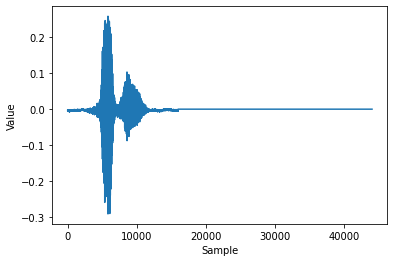

In [4]:
import matplotlib.pyplot as plt
audio = load_audio(paths[0])
plt.plot(audio.numpy().T)
plt.xlabel('Sample')
plt.ylabel('Value')

In [7]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
    stfts = tf.signal.stft(audio,
                           frame_length=1024,
                           frame_step=256,
                           fft_length=1024)
    spectograms = tf.abs(stfts)
    num_spectogram_bins = stfts.shape[-1] #.value
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    # compute mfccs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    return mfccs

Text(0, 0.5, 'Sample Value')

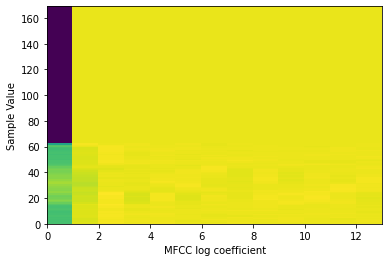

In [8]:
mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0])
plt.xlabel('MFCC log coefficient')
plt.ylabel('Sample Value')

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generate MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # repeat dataset forever
    ds = ds.repeat()
    # prepare batches
    ds = ds.batch(batch_size)
    # prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds =prep_ds(ds)

In [12]:
# show first batch of mfcc spectrum values
for x in train_ds.take(1):
    print(x)

tf.Tensor(
[[[[-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]]]


 [[[-4.6867157e+01 -3.6049349e+00 -7.3594236e+00 ... -2.1822487e-01
    -1.4503988e+00  4.1418642e-02]
   [-4.7343922e+01 -3.9652030e+00 -7.4302049e+00 ... -2.3312728e+00
    -3.2186608e+00  4.5675406e-01]
   [-4.8654289e+01 -4.4386497e+00 -7.0208702e+00 ... -1.6784549e+00
    -1.9266303e+00  2.2364730e-01]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726